In [37]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
from keras.layers import SimpleRNN
import tensorflow as tf


Functions that modify the Datasets

In [106]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors

def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(hour):
    hour = int(hour)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')
    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])

    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    
    #....................................................................
    #Let's create more columns to identify the seasons and time of day
    combined['Season'] = combined['Month'].apply(get_season)
    combined['Time_of_Day'] = combined['Hour'].apply(get_time_of_day)
    
    #OrdinalEncoder - convert categorical data in numerical
    encoder = OrdinalEncoder()
    combined[['Season', 'Time_of_Day']] = encoder.fit_transform(combined[['Season', 'Time_of_Day']])

    #....................................................................

    combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined


Functions to plot

In [3]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

We have loaded the dataframes and modified the formats so that they are similar

In [107]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})

In [96]:
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")


data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [224]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [7]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "illumination", "infrared", "light_level"])

In [8]:
data_sensors = rename_sensor(data_sensors)

In [9]:
data_sensors.shape

(193215, 9)

Missing Values

In [10]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2               616
humidity          798
o3             129341
pressure        32485
temperature       801
tvoc            32307
dtype: int64
Series([], dtype: float64)


In [11]:
#tarda como 25 min
"""data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [12]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
o3    129341
dtype: int64


Duplicates

In [13]:
data_sensors.duplicated().sum()

0

In [14]:
data_sensors.describe()

_field,co2,humidity,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [217]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

'# Convertir las columnas "Hour" y "Minutes" a enteros\ndata_sensors[\'Hour\'] = data_sensors[\'Hour\'].astype(int)\ndata_sensors[\'Minutes\'] = data_sensors[\'Minutes\'].astype(int)'

In [65]:
#data_sensors.to_csv("data_sensors_v1.csv",index=False)  

# Recommender System

In [108]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [109]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,NaN,976.2,22.7,184.0


In [110]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [111]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']

We combine the two datasets to have only one (for date and time and for each sensor)

In [112]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
c147446_com = combine_dataframes(c147446,data_meteo)
c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\4196384453.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_27644\4196384453.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_27644\4196384453.py:71: SettingWithCopyWarning: 
A value is trying to be set on a 

In [113]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,2.0,13,50,0.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,2.0,14,00,0.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,2.0,14,10,0.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,2.0,14,20,0.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,2.0,14,30,0.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,1.0,11,40,2.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,1.0,11,50,2.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,1.0,12,00,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,1.0,12,10,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


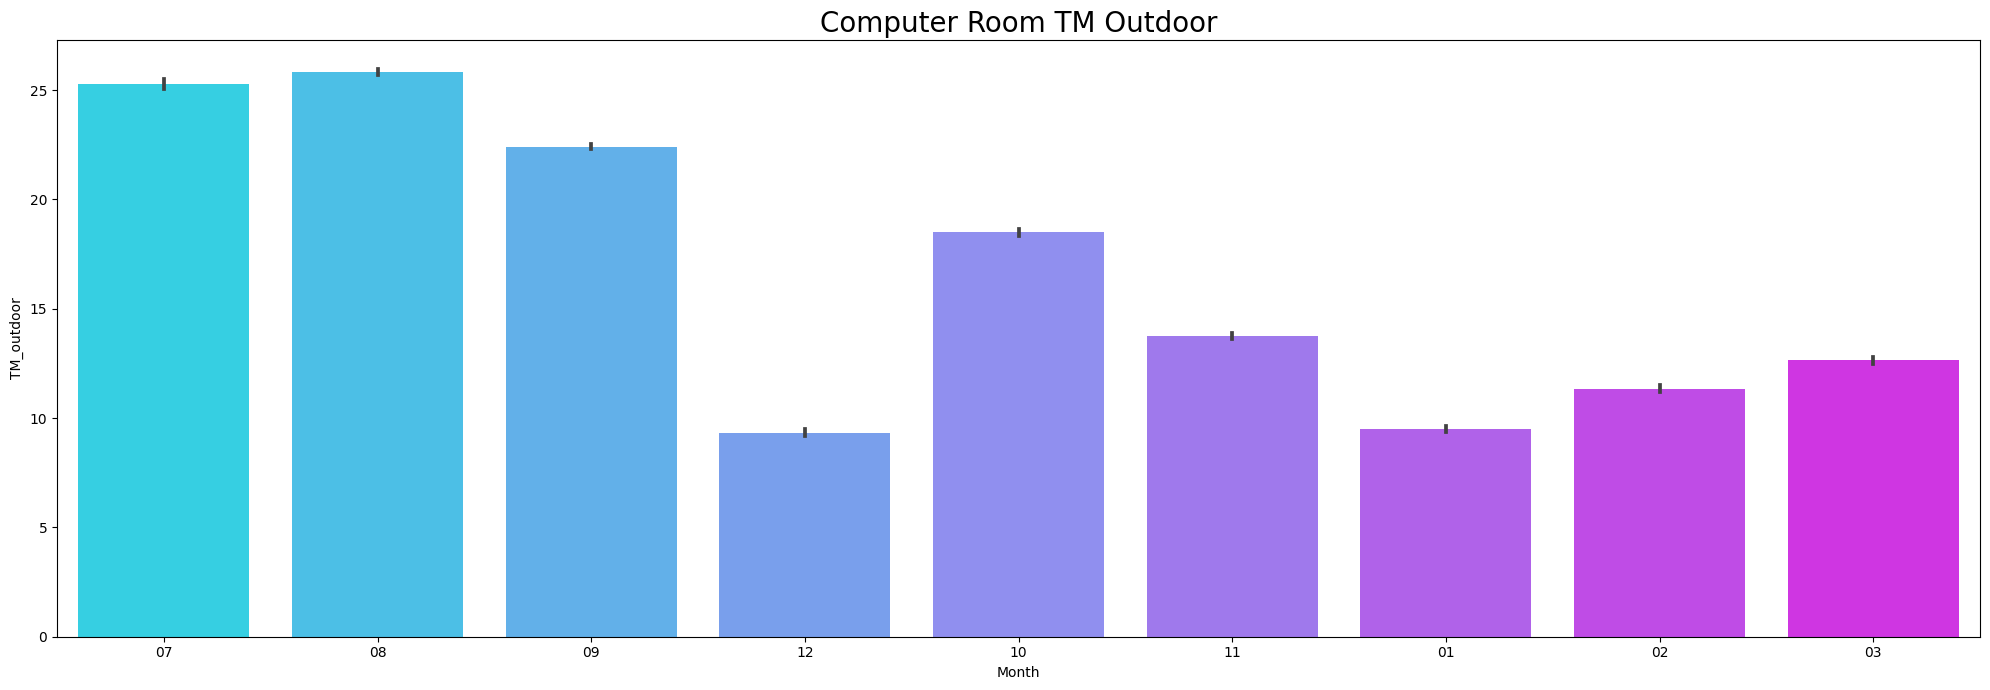

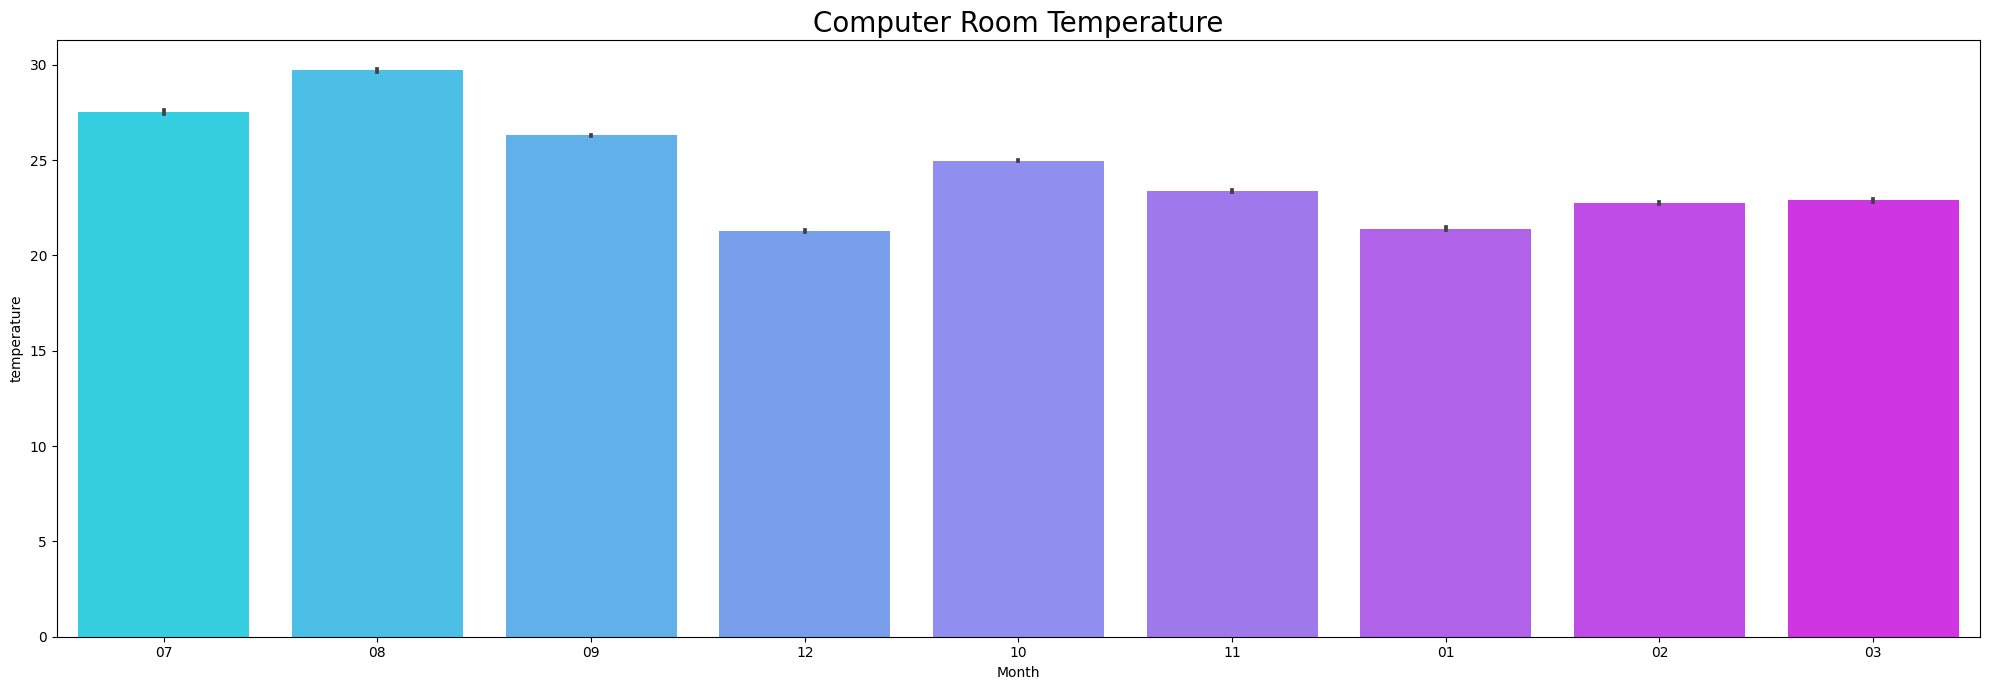

In [116]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [117]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
Season, n (%)          0.0         0   11225 (35.6)
                       1.0              3355 (10.7)
                       2.0              5347 (17.0)
                       3.0             11562 (36.7)
Time_of_Day, n (%)     0.0         0    7940 (25.2)
                       1.0              5232 (16.6)
                       2.0              9196 (29.2)
                       3.0              9121 (29.0)
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50.5               344 (1.1)
                       51.0               414 (1.3)
                       51.5               346 (1.1)
                       52.0               302 (1.0)
                       52.5               278 (0.9)
                       53

Tukey test indicates far outliers

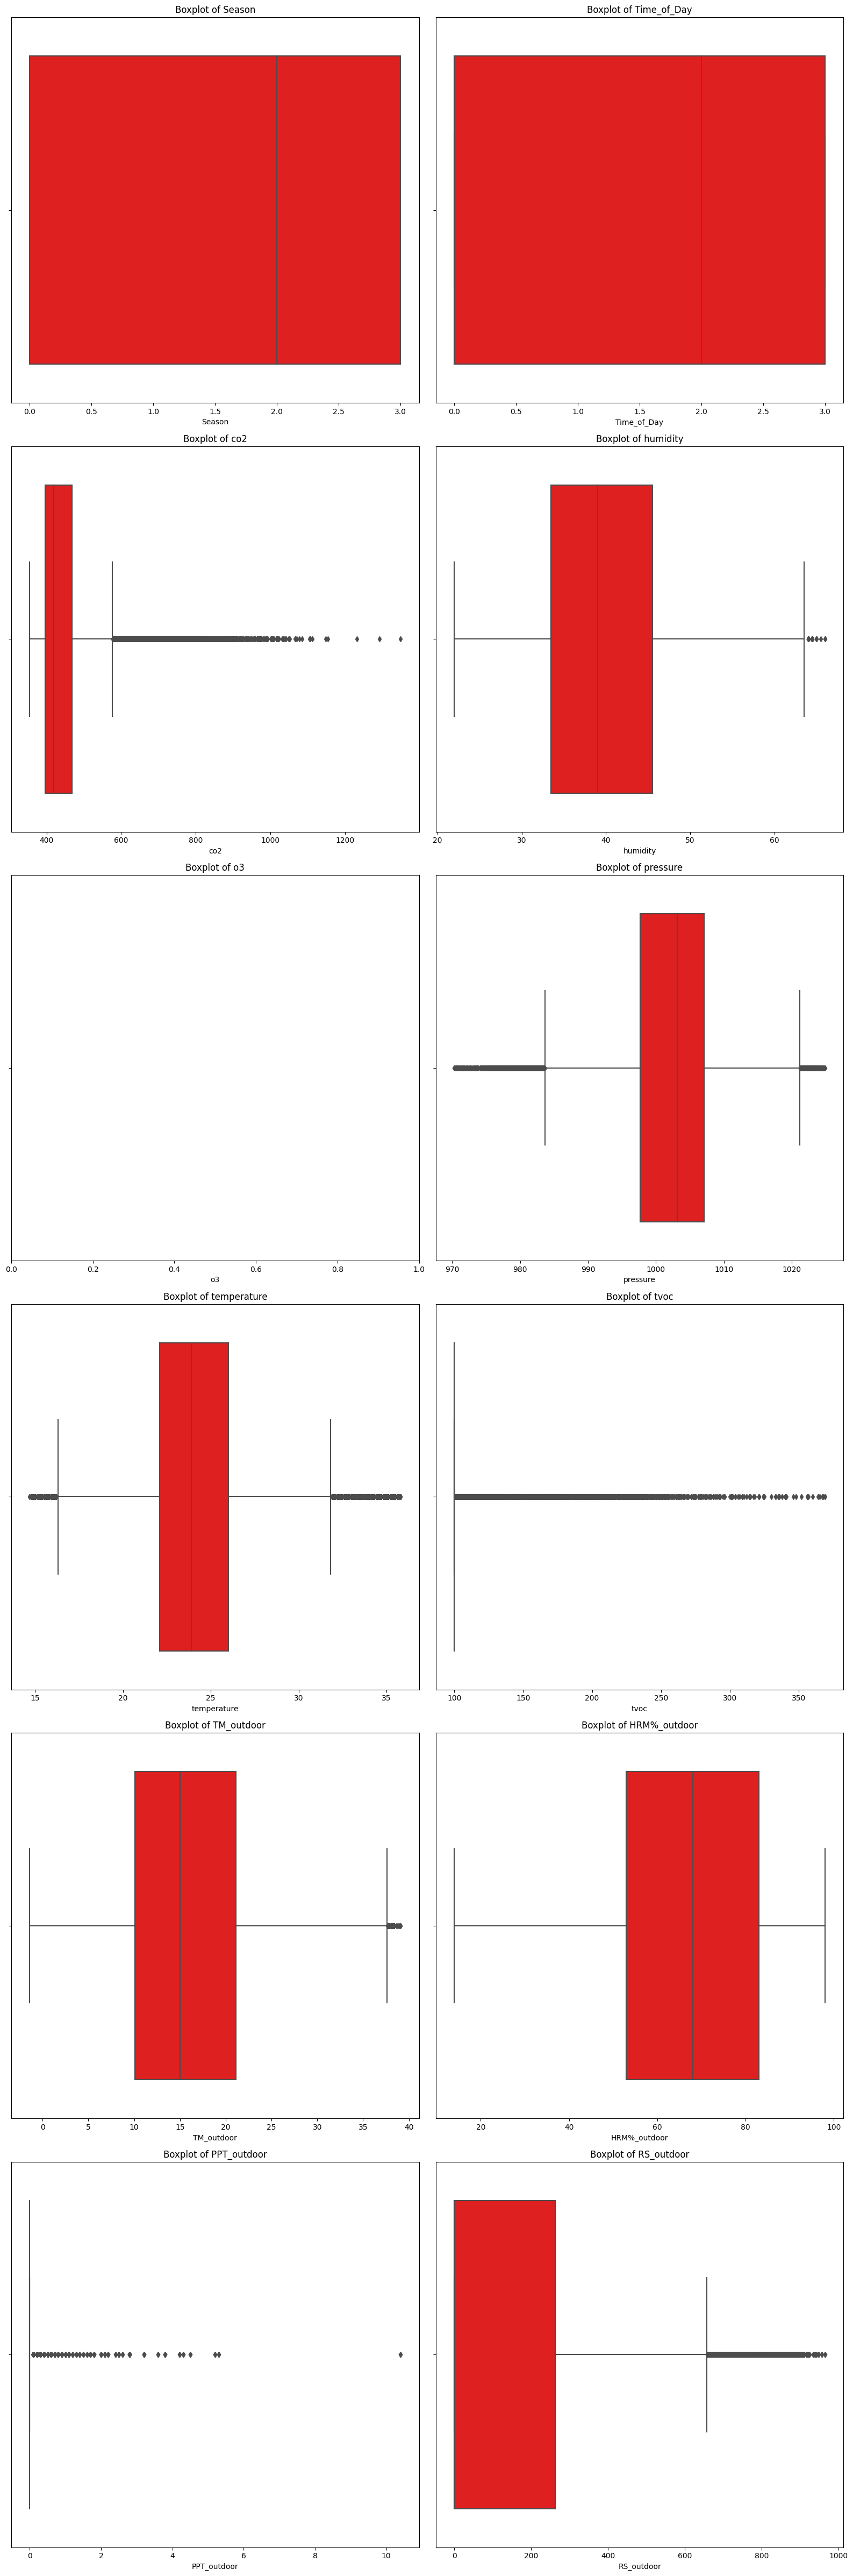

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [118]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""


Correlations

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\3494042682.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


<AxesSubplot:>

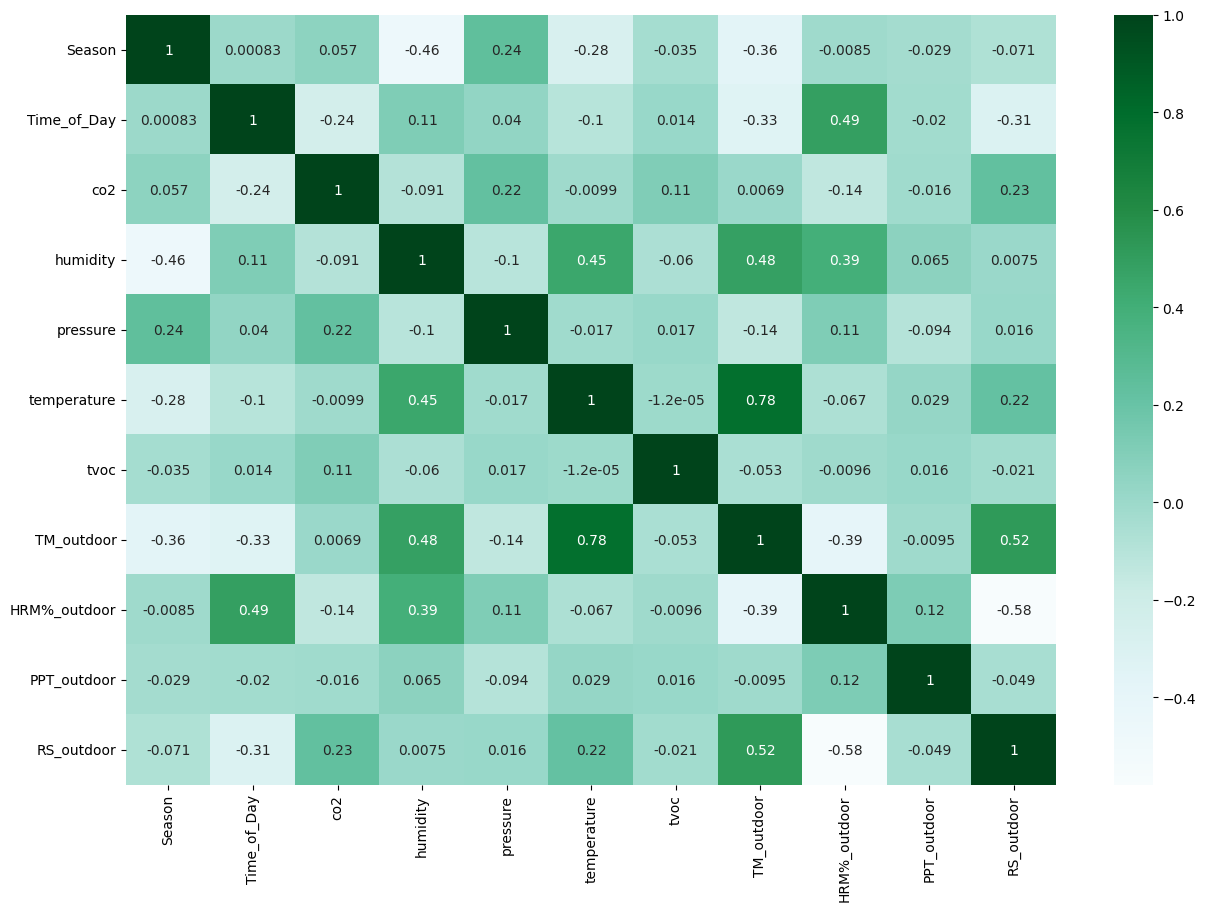

In [119]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

In [251]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,2.0,13,50,0.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,2.0,14,00,0.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,2.0,14,10,0.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,2.0,14,20,0.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,2.0,14,30,0.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,1.0,11,40,2.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,1.0,11,50,2.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,1.0,12,00,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,1.0,12,10,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


Bidirectional and Unidirectional LSTM

In [320]:
df_train=Computer_Room_com[['Day', "Hour","Minutes", 'Season',"Time_of_Day","humidity", 'HRM%_outdoor', 'RS_outdoor', "TM_outdoor", "temperature"]]
print(len(df_train.columns))

10


In [321]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

(31489, 10)

In [322]:
lags=8
forecasts=3
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 10), (31478, 8, 10), (31478, 3))

In [323]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25182, 8, 10), (25182, 3), (6296, 8, 10), (6296, 3))

In [324]:
X_train, y_train, X_val, y_val

(array([[[-0.48379056,  1.66548409,  0.29361855, ..., -0.65300698,
          -1.60014525, -0.74541989],
         [-0.48379056,  1.66548409,  0.87964597, ..., -0.65300698,
          -1.60014525, -0.74541989],
         [-0.48379056,  1.66548409,  1.46567339, ..., -0.65300698,
          -1.29662874, -0.74541989],
         ...,
         [-0.37374635, -1.66563587, -1.4644637 , ..., -0.65300698,
          -1.60014525, -0.77465969],
         [-0.37374635, -1.66563587, -0.87843628, ..., -0.65300698,
          -1.60014525, -0.77465969],
         [-0.37374635, -1.66563587, -0.29240887, ..., -0.65300698,
          -1.69251984, -0.77465969]],
 
        [[ 1.38696111,  0.79649627, -0.87843628, ..., -0.0392621 ,
           1.13150334,  0.51189149],
         [ 1.38696111,  0.79649627, -0.29240887, ..., -0.3980003 ,
           0.99953964,  0.39493229],
         [ 1.38696111,  0.79649627,  0.29361855, ..., -0.3980003 ,
           0.99953964,  0.36569249],
         ...,
         [ 1.38696111,  0.9413275

In [325]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)
model_bi = Sequential([Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
    Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.20),
    Dense(units=3, activation = 'linear'),
])
model_bi.compile(optimizer='adam', loss='mse')
model_bi.summary()
tf.keras.utils.plot_model(model_bi)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_39                │ (None, 8, 512)         │       546,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8, 20)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 8, 256)         │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 8, 20)          │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,571 (3.33 MB)

 Trainable params: 872,571 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [326]:
from tensorflow.keras.optimizers import Adam

n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
#input_shape=(n_steps, n_features)
model=Sequential()
model.add(LSTM(128,activation='tanh',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dense(3, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()
tf.keras.utils.plot_model(model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_87 (LSTM)                  │ (None, 8, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,795 (600.76 KB)

 Trainable params: 153,795 (600.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 0.0902 - val_loss: 0.0198
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0272 - val_loss: 0.0130
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0223 - val_loss: 0.0125
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0221 - val_loss: 0.0127
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 0.0207 - val_loss: 0.0099
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0213 - val_loss: 0.0101
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.0209 - val_loss: 0.0168
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0196 - val_loss: 0.0104
Epoch 8: early stopping


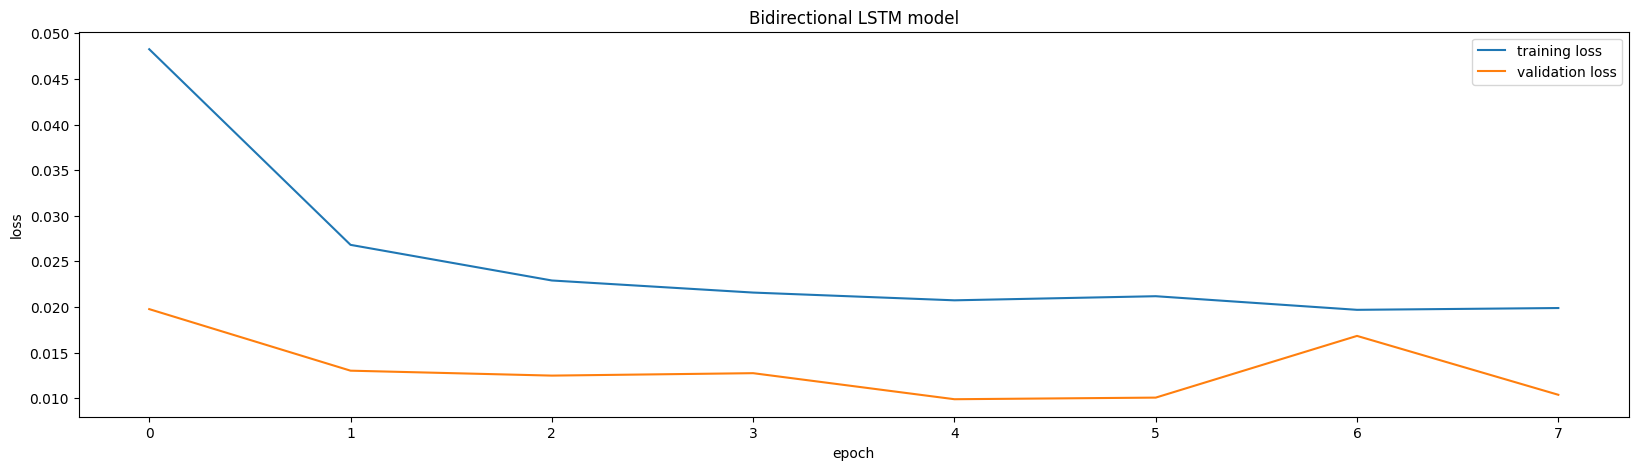

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.05612097970467198
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.007458075465521334
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.08607998786527077
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.22792756363431096
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9945646965226939
R2 of Bidirectional LSTM model : 0.99

 



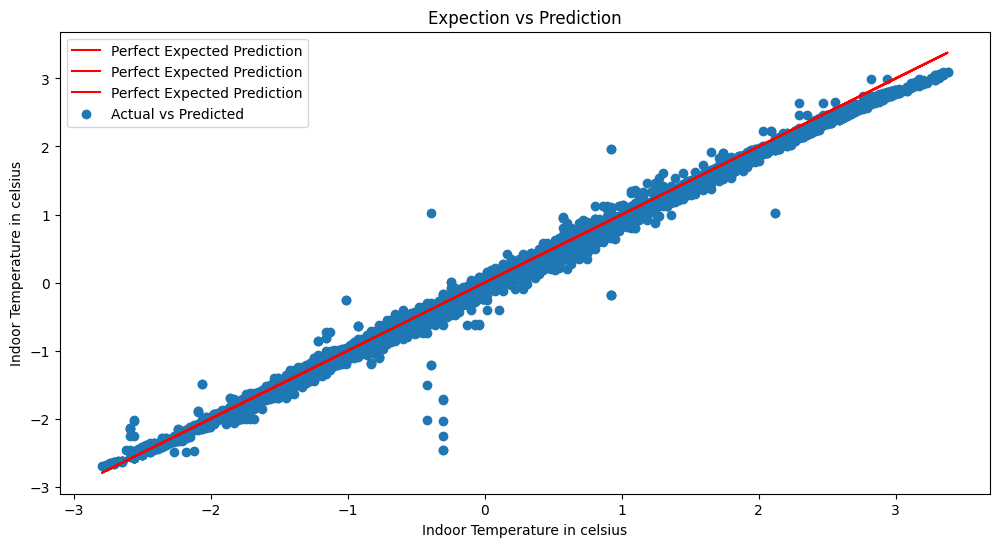

In [327]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=20,validation_split=0.01, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()


# Call the model_train_evaluation function
model_train_evaluation(y_val, X_val, model_bi, 'Bidirectional LSTM model')


Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.1285 - val_loss: 0.0218
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0072 - val_loss: 0.0101
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0069 - val_loss: 0.0101
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 8: early stopping


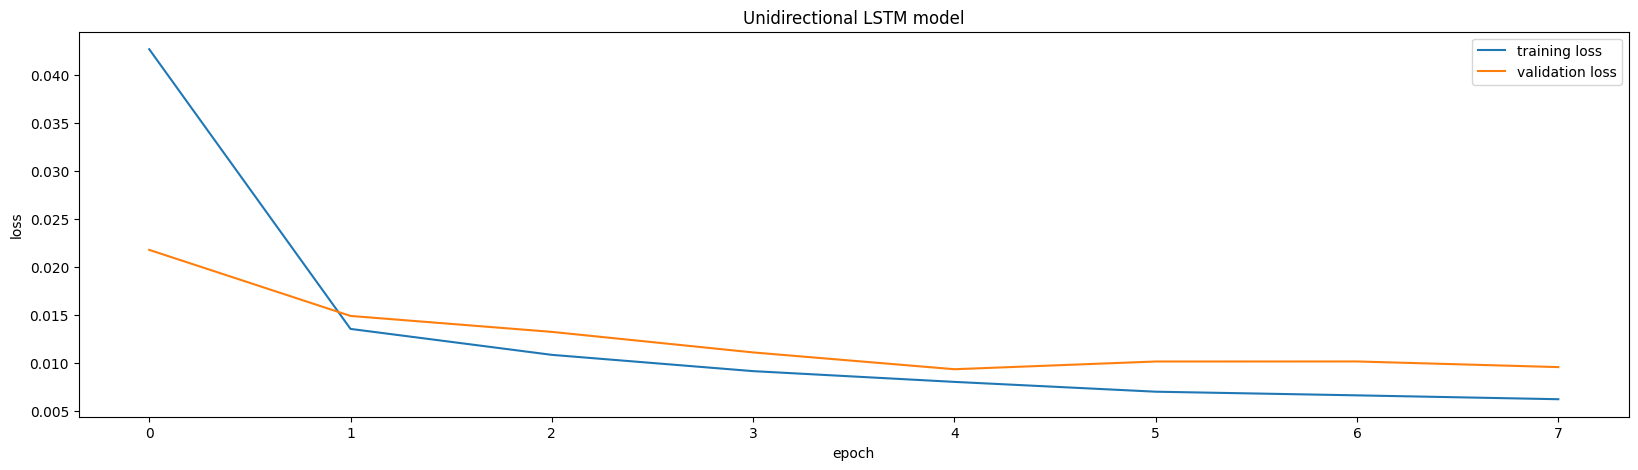

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM model : 0.04084155023543263
Mean Squared Error(MSE) of Unidirectional LSTM model : 0.005165280155713769
Root Mean Squared Error (RMSE) of Unidirectional LSTM model : 0.07135853447246626
Mean absolute percentage error (MAPE) of Unidirectional LSTM model : 0.1741527432354186
Explained Variance Score (EVS) of Unidirectional LSTM model : 0.9948342995723382
R2 of Unidirectional LSTM model : 0.99

 



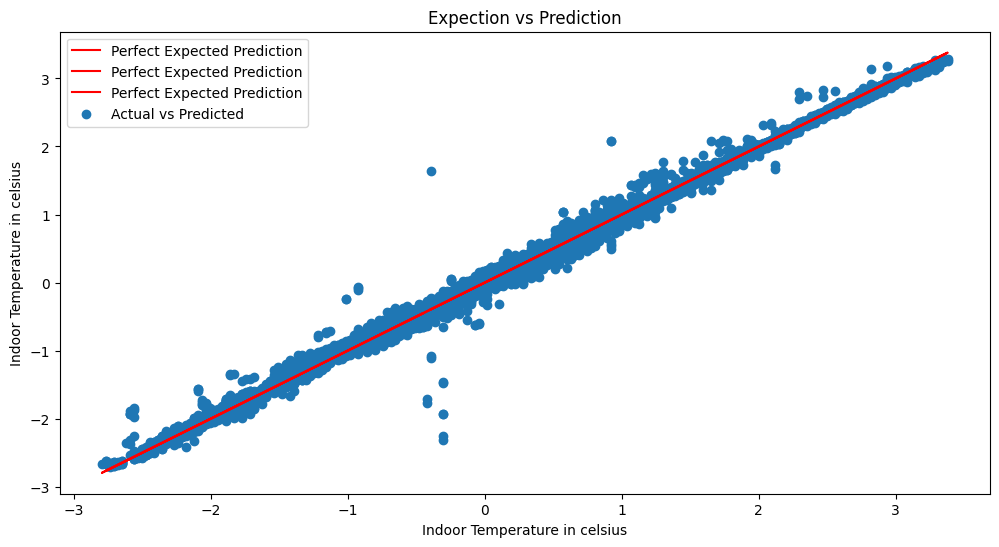

In [328]:
model_train_evaluation(y_val, X_val,model, 'Unidirectional LSTM model')

In [336]:
import pandas as pd

data_test = {
    'Day': ["08","08","08", "08","08", "08"],
    'Hour': ['12','12','12','13','13','13'],
    'Minutes': ['30', '40', '50', '00','10','20'],
    "Season": ['1.0', '1.0', '1.0', '1.0','1.0','1.0'],
    "Time_of_Day": ['0.0', '0.0', '0.0', '0.0','0.0','0.0'],
    #'co2': [405.0, 399.0, 403.0, 398.0],
    'humidity': [38.0, 37.5, 37.0, 36.5, 38.0, 37.5], 
    'TM_outdoor': [24.0, 24.0, 23.0, 23.4, 22.0, 19.0],
    'HRM%_outdoor': [44, 47, 47, 47, 44, 47],
    'RS_outdoor': [340, 340, 340, 340, 340, 340]
}

df_new = pd.DataFrame(data_test)

In [337]:
df_test=df_new[['Day', "Hour", "Minutes", 'Season',"Time_of_Day","humidity", 'HRM%_outdoor', 'RS_outdoor', "TM_outdoor"]]#, "temperature"]]
df_test

,Day,Hour,Minutes,Season,Time_of_Day,humidity,HRM%_outdoor,RS_outdoor,TM_outdoor
0,08,12,30,1.0,0.0,38.0,44,340,24.0
1,08,12,40,1.0,0.0,37.5,47,340,24.0
2,08,12,50,1.0,0.0,37.0,47,340,23.0
3,08,13,00,1.0,0.0,36.5,47,340,23.4
4,08,13,10,1.0,0.0,38.0,44,340,22.0
5,08,13,20,1.0,0.0,37.5,47,340,19.0


In [338]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\237083430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=df_train.append(df_test,ignore_index=True).fillna(0)


,Day,Hour,Minutes,Season,Time_of_Day,humidity,HRM%_outdoor,RS_outdoor,TM_outdoor,temperature
0,25,13,50,2.0,0.0,37.0,25,808,31.0,27.4
1,25,14,00,2.0,0.0,37.0,25,808,31.0,27.5
2,25,14,10,2.0,0.0,37.0,25,808,31.0,27.5
3,25,14,20,2.0,0.0,37.0,25,746,31.2,27.5
4,25,14,30,2.0,0.0,36.5,25,746,31.2,27.6
...,...,...,...,...,...,...,...,...,...,...
31490,08,12,40,1.0,0.0,37.5,47,340,24.0,0.0
31491,08,12,50,1.0,0.0,37.0,47,340,23.0,0.0
31492,08,13,00,1.0,0.0,36.5,47,340,23.4,0.0
31493,08,13,10,1.0,0.0,38.0,44,340,22.0,0.0


In [339]:
"""y_mean=df_train['TM_outdoor'].mean()
y_std=scaler.scale_[df_train.shape[1]-1]
print(y_mean, y_std)"""

y_mean=train_test['temperature'].mean()
y_std=scaler.scale_[train_test.shape[1]-1]
print(y_mean, y_std)

"""y_mean1=df_train['RS_outdoor'].mean()
y_std1=scaler.scale_[df_train.shape[1]-2]
print(y_mean1, y_std1)

y_mean2=df_train['HRM%_outdoor'].mean()
y_std2=scaler.scale_[df_train.shape[1]-3]
print(y_mean2, y_std2)

y_mean3=df_train['humidity'].mean()
y_std3=scaler.scale_[df_train.shape[1]-4]
print(y_mean3, y_std3)

y_mean4=df_train['temperature'].mean()
y_std4=scaler.scale_[df_train.shape[1]-5]
print(y_mean4, y_std4)"""

24.24471344657882 3.419996083263395


"y_mean1=df_train['RS_outdoor'].mean()\ny_std1=scaler.scale_[df_train.shape[1]-2]\nprint(y_mean1, y_std1)\n\ny_mean2=df_train['HRM%_outdoor'].mean()\ny_std2=scaler.scale_[df_train.shape[1]-3]\nprint(y_mean2, y_std2)\n\ny_mean3=df_train['humidity'].mean()\ny_std3=scaler.scale_[df_train.shape[1]-4]\nprint(y_mean3, y_std3)\n\ny_mean4=df_train['temperature'].mean()\ny_std4=scaler.scale_[df_train.shape[1]-5]\nprint(y_mean4, y_std4)"

In [340]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'temperature',]=val2
    

final_test1 = train_test[len(df_train):][['temperature']]

"""for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std1*val[:,0]+y_mean1
    train_test.loc[i,'RS_outdoor',]=val2
    

final_test2 = train_test[len(df_train):][['RS_outdoor']]


for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std2*val[:,0]+y_mean2
    train_test.loc[i,'HRM%_outdoor',]=val2
    

final_test3 = train_test[len(df_train):][['HRM%_outdoor']]


for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std3*val[:,0]+y_mean3
    train_test.loc[i,'humidity',]=val2
    

final_test4 = train_test[len(df_train):][['humidity']]

for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std4*val[:,0]+y_mean4
    train_test.loc[i,'temperature',]=val2
    

final_test5 = train_test[len(df_train):][['temperature']]"""


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


"for i in range(len(df_train),len(train_test)):\n    X_test=train_test[i-lags:i]\n    X_test=scaler.transform(X_test)\n    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))\n    val2=y_std1*val[:,0]+y_mean1\n    train_test.loc[i,'RS_outdoor',]=val2\n    \n\nfinal_test2 = train_test[len(df_train):][['RS_outdoor']]\n\n\nfor i in range(len(df_train),len(train_test)):\n    X_test=train_test[i-lags:i]\n    X_test=scaler.transform(X_test)\n    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))\n    val2=y_std2*val[:,0]+y_mean2\n    train_test.loc[i,'HRM%_outdoor',]=val2\n    \n\nfinal_test3 = train_test[len(df_train):][['HRM%_outdoor']]\n\n\nfor i in range(len(df_train),len(train_test)):\n    X_test=train_test[i-lags:i]\n    X_test=scaler.transform(X_test)\n    val=model.predict(X_test.reshape(1,lags,X_test.shape[1]))\n    val2=y_std3*val[:,0]+y_mean3\n    train_test.loc[i,'humidity',]=val2\n    \n\nfinal_test4 = train_test[len(df_train):][['humidity']]\n\nfor i in range(len(d

In [341]:
train_test

,Day,Hour,Minutes,Season,Time_of_Day,humidity,HRM%_outdoor,RS_outdoor,TM_outdoor,temperature
0,25,13,50,2.0,0.0,37.0,25,808,31.0,27.400000
1,25,14,00,2.0,0.0,37.0,25,808,31.0,27.500000
2,25,14,10,2.0,0.0,37.0,25,808,31.0,27.500000
3,25,14,20,2.0,0.0,37.0,25,746,31.2,27.500000
4,25,14,30,2.0,0.0,36.5,25,746,31.2,27.600000
...,...,...,...,...,...,...,...,...,...,...
31490,08,12,40,1.0,0.0,37.5,47,340,24.0,22.987883
31491,08,12,50,1.0,0.0,37.0,47,340,23.0,23.076714
31492,08,13,00,1.0,0.0,36.5,47,340,23.4,23.087818
31493,08,13,10,1.0,0.0,38.0,44,340,22.0,23.115704


In [376]:
class TemperaturePredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.model_1 = self.uni_LSTM(input_shape, output_units)
        self.model_2 = self.bi_LSTM(input_shape, output_units)

    def uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            tf.keras.layers.Dropout(0.20),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi


def train(y, X, model, model_name , num_epochs = 15):
    history = model.model.fit(X, y, epochs=num_epochs, validation_split=0.01)

    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()

    from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
    y_pred = model.model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name, ':', mean_absolute_error(y, y_pred))
    print('Mean Squared Error(MSE) of', model_name, ':', mean_squared_error(y, y_pred))
    print('Root Mean Squared Error (RMSE) of', model_name, ':', mean_squared_error(y, y_pred, squared=False))
    print('Mean absolute percentage error (MAPE) of', model_name, ':', mean_absolute_percentage_error(y, y_pred))
    print('Explained Variance Score (EVS) of', model_name, ':', explained_variance_score(y, y_pred))
    print('R2 of', model_name, ':', r2_score(y, y_pred).round(2))
    print('\n \n')

    plt.figure(figsize=(12, 6), dpi=100)
    plt.scatter(y, y_pred, label="Actual vs Predicted")
    # Predicciones perfectas
    plt.xlabel('Indoor Temperature in Celsius')
    plt.ylabel('Indoor Temperature in Celsius')
    plt.title('Expectation vs Prediction')
    plt.plot(y, y, 'r', label="Perfect Expected Prediction")
    plt.legend()
    plt.show()


Epoch 1/15


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3681 - val_loss: 0.0127
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179 - val_loss: 0.0118
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0174 - val_loss: 0.0093
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - val_loss: 0.0078
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0134 - val_loss: 0.0080
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - val_loss: 0.0081
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0131 - val_loss: 0.0083
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0116 - val_loss: 0.0064
Epoch 9/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - val_loss: 0.0055
Epoch 10/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - val_loss: 0.0064
Epoch 11/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 12/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.

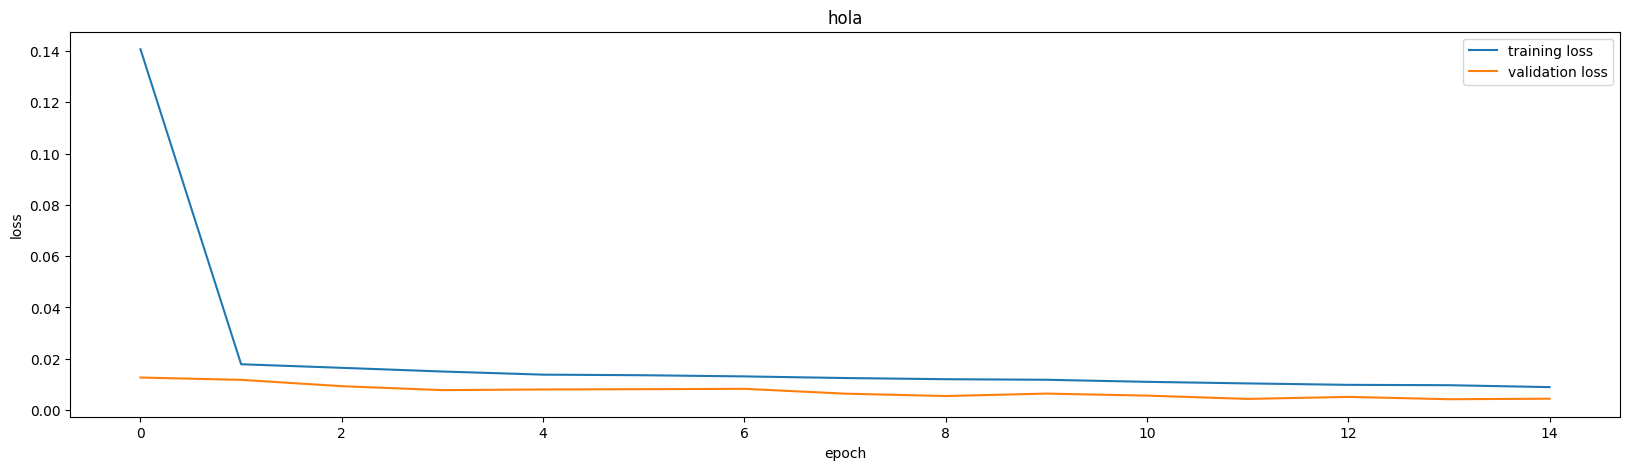

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of hola : 0.05135971957683145
Mean Squared Error(MSE) of hola : 0.00685784471306061
Root Mean Squared Error (RMSE) of hola : 0.08211084213337905
Mean absolute percentage error (MAPE) of hola : 0.2341918732620316
Explained Variance Score (EVS) of hola : 0.9933085394396982
R2 of hola : 0.99

 



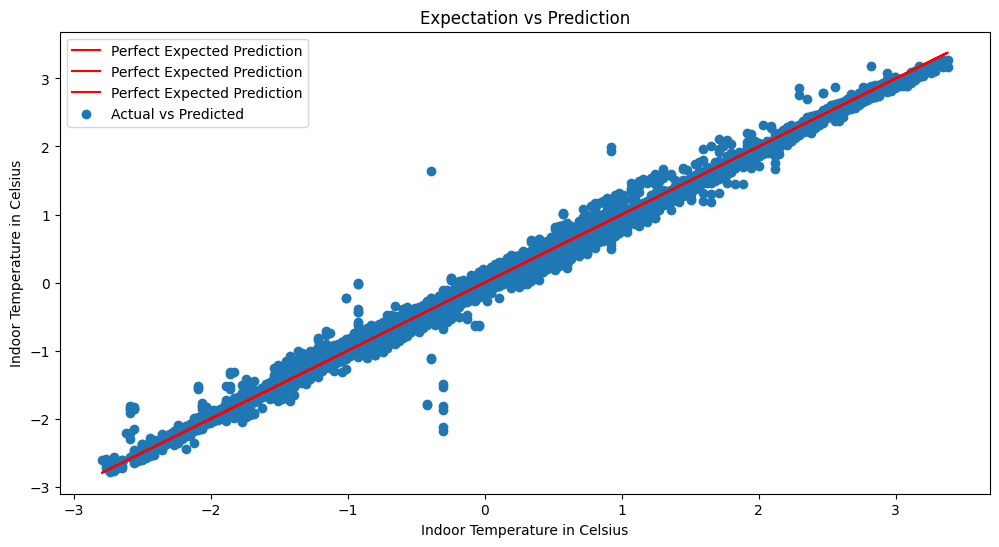

In [377]:
model = TemperaturePredictionModel(input_shape, output_units=3)
losses = train(y_val, X_val, model, "hola")